<a href="https://colab.research.google.com/github/dinachoir/Disaster-Tweets/blob/main/Natural_Language_Processing_with_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Natural Language Processing with Disaster Tweets**

## **Objective**
To predict which Tweets are about real disasters and which ones are not

## **Dataset**
The dataset is a [kaggle competition dataset](https://www.kaggle.com/competitions/nlp-getting-started/overview). This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website [here](https://www.figure-eight.com/data-for-everyone/). It contains 10,000 tweets that were hand classified.

**Columns**
1. id - a unique identifier for each tweet
2. text - the text of the tweet
3. location - the location the tweet was sent from (may be blank)
4. keyword - a particular keyword from the tweet (may be blank)
5. target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


## **Data**

In [ ]:
# load the data
import pandas as pd

train = pd.read_csv("/content/drive/MyDrive/Google Colab/Disaster Tweets/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Google Colab/Disaster Tweets/test.csv")

# Check out the training set
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Check out the testing set (doesn't have a target column)
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# Shuffle the training set
train_shuffled = train.sample(frac=1, random_state=42)
train_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# Check out the nummber of sample in each class (binary classification -> 2 classes)
train["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Training set contains around 60% negative class samples (target = 0, indicates not a real disaster tweet), and 40% positive class sample (target = 1, indicates a real disaster tweet). I'd say this proportion is quite balanced.

In [ ]:
# Check out the total samples of each set
print(f"Total training samples: {len(train)}")
print(f"Total testing samples: {len(test)}")
print(f"Total samples: {len(train) + len(test)}")

Total training samples: 7613
Total testing samples: 3263
Total samples: 10876


In [ ]:
# Visualize some random training samples
import random

random_index = random.randint(0, len(train)-5)
for row in train_shuffled[["text","target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}", "(real disaster tweet)" if target > 0 else "(not real disaster tweet)")
    print(f"Text:\n{text}\n")
    print("---\n")

Target: 1 (real disaster tweet)
Text:
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...

---

Target: 0 (not real disaster tweet)
Text:
Remember how Nora Jones crushed it in Two Weeks Notice?

---

Target: 0 (not real disaster tweet)
Text:
Coursing* '@WEYREY_gidi: Now they are causing Di Maria.. LOL'

---

Target: 1 (real disaster tweet)
Text:
#floods #ukfloods - British trekkers rescued amid flash floods in Himalayas: A group of British tr... http://t.co/nsfzkfgZnj - #flooding

---

Target: 0 (not real disaster tweet)
Text:
Detonation into the realistic assets entering india: koZ http://t.co/9ZRQMd8nGZ

---



In [ ]:
# Split training set into training and validation sets

from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_shuffled["text"],
                                                                           train_shuffled["target"],
                                                                           test_size=0.1,
                                                                           random_state=42)

In [ ]:
# Check the number of sample after splitting
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
# View the first 10 training samples
train_sentences[:10], train_labels[:10]

(5921    @mogacola @zamtriossu i screamed after hitting...
 3904              Imagine getting flattened by Kurt Zouma
 2804    @Gurmeetramrahim #MSGDoing111WelfareWorks Gree...
 3718    @shakjn @C7 @Magnums im shaking in fear he's g...
 1667    Somehow find you and I collide http://t.co/Ee8...
 4435    @EvaHanderek @MarleyKnysh great times until th...
 2544                     destroy the free fandom honestly
 7223    Weapons stolen from National Guard Armory in N...
 4265    @wfaaweather Pete when will the heat wave pass...
 6568    Patient-reported outcomes in long-term survivo...
 Name: text, dtype: object, 5921    0
 3904    0
 2804    1
 3718    0
 1667    0
 4435    1
 2544    1
 7223    0
 4265    1
 6568    1
 Name: target, dtype: int64)

## **Convert Text into Numbers**

### **Tokenization**

A straight mapping from word or character or sub-word to a numerical value. 

In [ ]:
# Find the average number of token (words) in the training set
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
# Text vectorization (Tokenization)
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_vocab_length = 10000
max_length = 15
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                   standardize="lower_and_strip_punctuation",
                                   split="whitespace",
                                   ngrams=None,
                                   output_mode="int",
                                   output_sequence_length=max_length)

In [ ]:
# Fit text_vectorizer to the training set (mapping TextVectorization to data)
text_vectorizer.adapt(train_sentences)

In [ ]:
# Try to tokenize a sample sentence 
sample_sentence = "I can see a fire on the top of building!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  8,  71,  99,   3,  42,  11,   2, 212,   6, 630,   0,   0,   0,
          0,   0]])>

In [ ]:
# Try to tokenize a random sentence in training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nTokenized text:")
text_vectorizer([random_sentence])

Original text:
Men escape car engulfed in flames in Parley's Canyon crews investigating cause - http://t.co/CYzlshlQhG http://t.co/nDiS8f1vzt      

Tokenized text:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 646, 1084,  127,  436,    4,  218,    4, 2025, 1704,  689, 1130,
         257,    1,    1,    0]])>

In [ ]:
# Get the unique words in the vocabulary
vocab = text_vectorizer.get_vocabulary()
# most common words
top5_words = vocab[:5]
# least common words
bottom5_words = vocab[-5:]

print(f"Number of words in vocabulary: {len(vocab)}")
print(f"Top 5 most common words in vocabulary: {top5_words}")
print(f"Top 5 least common words in vocabulary: {bottom5_words}")

Number of words in vocabulary: 10000
Top 5 most common words in vocabulary: ['', '[UNK]', 'the', 'a', 'in']
Top 5 least common words in vocabulary: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### **Embedding**

An embedding can be learned during training, means word's numeric representation can be improved as the model goes through training set. 

**Main parameters**

1. **input_dim** - the size of the vocabulary
2. **output_dim** - the size of the output embedding vector
3. **embeddings_initializer** - how to initialize the embedding matrix.
4. **input_length** - length of sequences being passed to embedding layer

In [ ]:
from tensorflow.keras import layers

# set random seed
tf.random.set_seed(42)

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform", 
                             input_length=max_length,
                             name="embedding_layer_1")

embedding

In [ ]:
# Try to embed a random sentence in training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nTokenized text:")
embedded_sentence = embedding(text_vectorizer([random_sentence]))
embedded_sentence

Original text:
Ford : Other Military VERY NICE M151A1 MUTT with matching M416 Trailer - Full read by eBay http://t.co/9rrYaYlgyY http://t.co/Nm83jOhLUu      

Tokenized text:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02191793, -0.03392842,  0.02733031, ...,  0.04151938,
          0.01253768, -0.02994139],
        [ 0.0049196 ,  0.02093172,  0.01630242, ...,  0.01699087,
         -0.02467427, -0.02744926],
        [-0.0329975 ,  0.00978688, -0.04553537, ...,  0.04971104,
          0.0137558 ,  0.04985643],
        ...,
        [ 0.0152874 ,  0.00285798, -0.01921637, ..., -0.0020377 ,
          0.00328779,  0.00735877],
        [-0.01299536, -0.03285937,  0.02369577, ...,  0.01118424,
         -0.04721683,  0.00531303],
        [ 0.03177475, -0.00860753, -0.03964424, ...,  0.01106938,
          0.01294775,  0.01531184]]], dtype=float32)>

In [ ]:
# View single token's embedding
embedded_sentence[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 2.19179280e-02, -3.39284167e-02,  2.73303129e-02,  2.01102346e-03,
       -1.15370266e-02, -2.54076719e-03,  2.95269378e-02,  1.57040469e-02,
        2.28413679e-02,  1.79539993e-03,  1.86964907e-02,  2.91857831e-02,
        2.74629258e-02,  4.14859317e-02,  4.14177030e-03,  2.73332857e-02,
       -1.54885054e-02, -2.51211654e-02,  3.25003304e-02, -1.48203373e-02,
       -2.29279883e-02,  9.79628414e-03,  4.58561219e-02, -7.80185312e-03,
        9.03606415e-05,  5.55591658e-03,  1.74780823e-02,  6.65454939e-03,
        2.02755816e-02,  4.24134023e-02, -1.21730790e-02, -2.91831139e-02,
       -2.09597498e-03,  3.24255489e-02,  2.07848437e-02,  4.87247854e-03,
       -2.73485109e-03,  2.09287666e-02, -4.74381223e-02, -9.48175043e-03,
       -3.91733423e-02, -2.06283927e-02,  3.91446054e-04,  6.53488562e-03,
        6.76950067e-03, -3.77741680e-02, -4.66855764e-02, -3.43727693e-02,
        4.74652685e-02, -4.66058254e-02,  7.65633583

## **Modeling:**

1. Construct model's architecture
2. Train the model
3. Make prediction with the model
4. Evaluate the model and compare performances

## **Model 0 (baseline) : Naive Bayes**

**Modeling Setup:**
1. Convert words into numbers using TfidfVectorizer
2. Model with multinomial naive bayes algorithm

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

# fit the pipeline to the training set
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate the model on validation set
model_0_accuracy = model_0.score(val_sentences, val_labels)
print(f"Baseline model achieves an accuracy of {model_0_accuracy*100:.2f}%")

Baseline model achieves an accuracy of 79.27%


In [ ]:
# Make predictions
model_0_preds = model_0.predict(val_sentences)
model_0_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

In [ ]:
# Get prediction probability
import numpy as np
model_0_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1)
model_0_pred_probs[:10]

array([0.55507546, 0.70165655, 0.86646023, 0.78011348, 0.63190603,
       0.8216631 , 0.5759222 , 0.90335826, 0.73121414, 0.82175747])

In [ ]:
!wget https://raw.githubusercontent.com/dinachoir/Convolutional-Neural-Network/main/functions.py

--2022-07-17 02:11:20--  https://raw.githubusercontent.com/dinachoir/Convolutional-Neural-Network/main/functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9697 (9.5K) [text/plain]
Saving to: ‘functions.py’

functions.py        100%[===================>]   9.47K  --.-KB/s    in 0s      

2022-07-17 02:11:20 (84.5 MB/s) - ‘functions.py’ saved [9697/9697]



In [ ]:
# Model evaluation
from functions import evaluate_prediction

model_0_evaluation = evaluate_prediction(y_true=val_labels, 
                              y_pred=model_0_preds)

model_0_evaluation

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## **Model 1 (Dense model) : Feed-forward Neural Network**

In [ ]:
# Create Tensorboard Callback 
from functions import create_tensorboard_callback

checkpoint_path = "dense_model_checkpoints" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [ ]:
# Build model's architecture with funtional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x) # condense the dimension of the tensor
outputs = layers.Dense(1, activation="sigmoid")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_Dense")

# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
# Check model summary
model_1.summary()

Model: "model_1_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_layer_1 (Embeddin  (None, 15, 128)          1280000   
 g)                                                              
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                     

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback("model_logs",
                                                                     "dense_model")])

Saving Tensorboard log files to model_logs/dense_model/20220717-021120
Epoch 1/5
215/215 [==============================] - 5s 5ms/step - loss: 0.6094 - accuracy: 0.6916 - val_loss: 0.5357 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4410 - accuracy: 0.8189 - val_loss: 0.4691 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3463 - accuracy: 0.8605 - val_loss: 0.4590 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2848 - accuracy: 0.8923 - val_loss: 0.4641 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2380 - accuracy: 0.9118 - val_loss: 0.4767 - val_accuracy: 0.7874


In [ ]:
# Evaluate model in validation set
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4767 - accuracy: 0.7874


[0.47668465971946716, 0.787401556968689]

In [ ]:
# Check out embedding weights
embedding.weights

[<tf.Variable 'embedding_layer_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.00073165,  0.01504801, -0.03425453, ..., -0.04403539,
         -0.0104228 ,  0.01876437],
        [ 0.0413586 , -0.03945086, -0.03811941, ...,  0.00464736,
          0.03163553,  0.029283  ],
        [ 0.00684031,  0.05363133, -0.00241554, ..., -0.07082175,
         -0.04750704,  0.01448254],
        ...,
        [-0.03301444, -0.0052493 , -0.04209725, ...,  0.02028764,
          0.00308807,  0.02215792],
        [ 0.00692343,  0.05942352, -0.01975194, ..., -0.06199061,
         -0.01018393,  0.03510419],
        [-0.0372346 ,  0.06267187, -0.07451146, ..., -0.02367218,
         -0.08643329,  0.01742156]], dtype=float32)>]

In [ ]:
# The weights matrix of embedding layer
embedding_weights = model_1.get_layer("embedding_layer_1").get_weights()[0]
embedding_weights.shape

(10000, 128)

In [ ]:
# Make predictions
model_1_preds_probs = model_1.predict(val_sentences)
model_1_preds_probs[:10] # result prediction probability

array([[0.4048821 ],
       [0.7443312 ],
       [0.997895  ],
       [0.10890001],
       [0.11143532],
       [0.93556094],
       [0.9134595 ],
       [0.9925345 ],
       [0.97156817],
       [0.26570344]], dtype=float32)

In [ ]:
# Convert prediction probability to prediction class
model_1_preds = tf.squeeze(tf.round(model_1_preds_probs)) # tf.squeeze removes single dimension
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Model Evaluation
model_1_evaluation = evaluate_prediction(y_true=val_labels, 
                              y_pred=model_1_preds)

model_1_evaluation

{'accuracy': 78.74015748031496,
 'f1': 0.7846966492209201,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497}

In [ ]:
# Model Comparison (Did model_1 perform better than model_0 (baseline)?)
import numpy as np
np.array(list(model_1_evaluation.values())) > np.array(list(model_0_evaluation.values()))

array([False, False, False, False])

In [ ]:
# Create function to compare model's performances

def compare_baseline_to_new_model(baseline_evaluation, new_model_evaluation):
  for key, value in baseline_evaluation.items():
    print(f"Baseline {key}: {value:.2f}, New_model {key}: {new_model_evaluation[key]:.2f}, Difference: {new_model_evaluation[key]-value:.2f}")

compare_baseline_to_new_model(baseline_evaluation=model_0_evaluation,
                              new_model_evaluation=model_1_evaluation)

Baseline accuracy: 79.27, New_model accuracy: 78.74, Difference: -0.52
Baseline precision: 0.81, New_model precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New_model recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New_model f1: 0.78, Difference: -0.00


## **Model 2 (RNN model) : LSTM Model**

Adding a LSTM layer between embedding layer and output layer in model_1.

In [ ]:
# Create Tensorboard Callback 
from functions import create_tensorboard_callback

checkpoint_path = "lstm_model_checkpoints" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [ ]:
# Create embedding layer for model_2 
## because embedding weights get updated during training, do not reuse trained embedding in another models
## else, it would be mixing what one model learned with the next. it results uneven comparison between models.
from tensorflow.keras import layers

# set random seed
tf.random.set_seed(42)

model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform", 
                             input_length=max_length,
                             name="embedding_layer_2")
model_2_embedding

In [ ]:
# Create LSTM model
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


(None, 15, 128)
(None, 64)


In [ ]:
# Check model summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_layer_2 (Embeddin  (None, 15, 128)          1280000   
 g)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
No

In [ ]:
# Fit the model
history_model_2 = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback("model_logs",
                                                                     "lstm_model")])

Saving Tensorboard log files to model_logs/lstm_model/20220717-021132
Epoch 1/5
215/215 [==============================] - 6s 8ms/step - loss: 0.5100 - accuracy: 0.7416 - val_loss: 0.4566 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3176 - accuracy: 0.8717 - val_loss: 0.5138 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2201 - accuracy: 0.9152 - val_loss: 0.5858 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1556 - accuracy: 0.9428 - val_loss: 0.6041 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1076 - accuracy: 0.9594 - val_loss: 0.8746 - val_accuracy: 0.7507


In [ ]:
# Make predictions
model_2_preds_probs = model_2.predict(val_sentences)
model_2_preds_probs.shape, model_2_preds_probs[:10] # result prediction probability

((762, 1), array([[0.007126  ],
        [0.7873678 ],
        [0.9996376 ],
        [0.05679176],
        [0.0025822 ],
        [0.9996238 ],
        [0.92170197],
        [0.9997993 ],
        [0.9994954 ],
        [0.6645739 ]], dtype=float32))

In [ ]:
# Convert prediction probability to prediction class
model_2_preds = tf.squeeze(tf.round(model_2_preds_probs)) # tf.squeeze removes single dimension
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Model Evaluation
model_2_evaluation = evaluate_prediction(y_true=val_labels, 
                              y_pred=model_2_preds)

model_2_evaluation

{'accuracy': 75.06561679790026,
 'f1': 0.7489268622514025,
 'precision': 0.7510077975908164,
 'recall': 0.7506561679790026}

In [ ]:
# Compare model_2 to model_0 (baseline)
compare_baseline_to_new_model(baseline_evaluation=model_0_evaluation,
                              new_model_evaluation=model_2_evaluation)

Baseline accuracy: 79.27, New_model accuracy: 75.07, Difference: -4.20
Baseline precision: 0.81, New_model precision: 0.75, Difference: -0.06
Baseline recall: 0.79, New_model recall: 0.75, Difference: -0.04
Baseline f1: 0.79, New_model f1: 0.75, Difference: -0.04


## **Model 3 (RNN model) : GRU Model**

Gated Recurrent Unit (GRU) similar to LSTM with less parameters.

In [ ]:
# Create Tensorboard Callback 
from functions import create_tensorboard_callback

checkpoint_path = "gru_model_checkpoints" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [ ]:
# Create embedding layer for model_3
## because embedding weights get updated during training, do not reuse trained embedding in another models
## else, it would be mixing what one model learned with the next. it results uneven comparison between models.
from tensorflow.keras import layers

# set random seed
tf.random.set_seed(42)

model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform", 
                             input_length=max_length,
                             name="embedding_layer_3")
model_3_embedding

In [ ]:
# Create GRU model
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
# Check model summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_layer_3 (Embeddin  (None, 15, 128)          1280000   
 g)                                                              
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non

In [ ]:
# Fit the model
history_model_3 = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback("model_logs",
                                                                     "gru_model")])

Saving Tensorboard log files to model_logs/gru_model/20220717-021145
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.5242 - accuracy: 0.7314 - val_loss: 0.4553 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3195 - accuracy: 0.8694 - val_loss: 0.4937 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2197 - accuracy: 0.9181 - val_loss: 0.5607 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1599 - accuracy: 0.9441 - val_loss: 0.6220 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1221 - accuracy: 0.9584 - val_loss: 0.6205 - val_accuracy: 0.7677


In [ ]:
# Make predictions
model_3_preds_probs = model_3.predict(val_sentences)
model_3_preds_probs.shape, model_3_preds_probs[:10] # result prediction probability

((762, 1), array([[0.33325273],
        [0.87741184],
        [0.9980252 ],
        [0.11561756],
        [0.01235959],
        [0.9925639 ],
        [0.6214262 ],
        [0.99813336],
        [0.9982377 ],
        [0.5018107 ]], dtype=float32))

In [ ]:
# Convert prediction probability to prediction class
model_3_preds = tf.squeeze(tf.round(model_3_preds_probs)) # tf.squeeze removes single dimension
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Model Evaluation
model_3_evaluation = evaluate_prediction(y_true=val_labels, 
                              y_pred=model_3_preds)

model_3_evaluation

{'accuracy': 76.77165354330708,
 'f1': 0.7667932666650168,
 'precision': 0.7675450859410361,
 'recall': 0.7677165354330708}

In [ ]:
# Compare model_3 to model_0 (baseline)
compare_baseline_to_new_model(baseline_evaluation=model_0_evaluation,
                              new_model_evaluation=model_3_evaluation)

Baseline accuracy: 79.27, New_model accuracy: 76.77, Difference: -2.49
Baseline precision: 0.81, New_model precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New_model recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New_model f1: 0.77, Difference: -0.02


## **Model 4 : Bidirectional RNN Model**

Bidirectional RNN will process the sequences from left to right and then again from right to left. This algorithm costs longer training time and increased model parameters.

In [ ]:
# Create Tensorboard Callback 
from functions import create_tensorboard_callback

checkpoint_path = "bidirectional_model_checkpoints" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [ ]:
# Create embedding layer for model_4
## because embedding weights get updated during training, do not reuse trained embedding in another models
## else, it would be mixing what one model learned with the next. it results uneven comparison between models.
from tensorflow.keras import layers

# set random seed
tf.random.set_seed(42)

model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform", 
                             input_length=max_length,
                             name="embedding_layer_4")
model_4_embedding

In [ ]:
# Create the model
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Check model summary
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_layer_4 (Embeddin  (None, 15, 128)          1280000   
 g)                                                              
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                             

In [ ]:
# Fit the model
history_model_4 = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback("model_logs",
                                                                     "bidirectional_model")])

Saving Tensorboard log files to model_logs/bidirectional_model/20220717-021155
Epoch 1/5
215/215 [==============================] - 6s 11ms/step - loss: 0.5093 - accuracy: 0.7481 - val_loss: 0.4606 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3135 - accuracy: 0.8708 - val_loss: 0.5144 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2150 - accuracy: 0.9178 - val_loss: 0.5626 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1523 - accuracy: 0.9469 - val_loss: 0.6365 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1083 - accuracy: 0.9639 - val_loss: 0.6509 - val_accuracy: 0.7664


In [ ]:
# Make predictions
model_4_preds_probs = model_4.predict(val_sentences)
model_4_preds_probs.shape, model_4_preds_probs[:10] # result prediction probability

((762, 1), array([[0.04000055],
        [0.8279291 ],
        [0.99842227],
        [0.13531098],
        [0.00311338],
        [0.99220747],
        [0.95528346],
        [0.99945647],
        [0.99898285],
        [0.28141677]], dtype=float32))

In [ ]:
# Convert prediction probability to prediction class
model_4_preds = tf.squeeze(tf.round(model_4_preds_probs)) # tf.squeeze removes single dimension
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Model Evaluation
model_4_evaluation = evaluate_prediction(y_true=val_labels, 
                              y_pred=model_4_preds)

model_4_evaluation

{'accuracy': 76.64041994750657,
 'f1': 0.7651213533864446,
 'precision': 0.7665895370389821,
 'recall': 0.7664041994750657}

In [ ]:
# Compare model_4 to model_0 (baseline)
compare_baseline_to_new_model(baseline_evaluation=model_0_evaluation,
                              new_model_evaluation=model_4_evaluation)

Baseline accuracy: 79.27, New_model accuracy: 76.64, Difference: -2.62
Baseline precision: 0.81, New_model precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New_model recall: 0.77, Difference: -0.03
Baseline f1: 0.79, New_model f1: 0.77, Difference: -0.02


## **Model 5 (CNN model) : 1D-CNN Model**

In [ ]:
# Create Tensorboard Callback 
from functions import create_tensorboard_callback

checkpoint_path = "1dcnn_model_checkpoints" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [ ]:
# Testing out the embedding, Conv1D, and max pooling
embedding_test = embedding(text_vectorizer(["Testing out the embedding"]))

conv_1d_output = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(embedding_test) # pass embedding to convolutional 1D layer
max_pool_output = layers.GlobalMaxPool1D()(conv_1d_output)

# Check the tensor shape
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [ ]:
# View the output of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.06301616,  0.0237228 , -0.01208254, ...,  0.00464593,
           0.06175403, -0.05745464],
         [-0.05126509,  0.09102038, -0.04912858, ..., -0.03403544,
          -0.07990677,  0.05699109],
         [ 0.00684031,  0.05363133, -0.00241554, ..., -0.07082175,
          -0.04750704,  0.01448254],
         ...,
         [ 0.00073165,  0.01504801, -0.03425453, ..., -0.04403539,
          -0.0104228 ,  0.01876437],
         [ 0.00073165,  0.01504801, -0.03425453, ..., -0.04403539,
          -0.0104228 ,  0.01876437],
         [ 0.00073165,  0.01504801, -0.03425453, ..., -0.04403539,
          -0.0104228 ,  0.01876437]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.0209246 , 0.0432021 , 0.        , 0.05410302, 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.04170065, 0.        , 0.02664686, 0.        , 0.03347984,
          0.00081568, 0.

In [ ]:
# Create embedding layer for model_4
## because embedding weights get updated during training, do not reuse trained embedding in another models
## else, it would be mixing what one model learned with the next. it results uneven comparison between models.
from tensorflow.keras import layers

# set random seed
tf.random.set_seed(42)

model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform", 
                             input_length=max_length,
                             name="embedding_layer_5")
model_5_embedding

In [ ]:
# Create the model
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Check model summary
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_layer_5 (Embeddin  (None, 15, 128)          1280000   
 g)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                    

In [ ]:
# Fit the model
history_model_5 = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback("model_logs",
                                                                     "conv1d_model")])

Saving Tensorboard log files to model_logs/conv1d_model/20220717-021215
Epoch 1/5
215/215 [==============================] - 3s 6ms/step - loss: 0.5652 - accuracy: 0.7141 - val_loss: 0.4733 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3380 - accuracy: 0.8615 - val_loss: 0.4758 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2070 - accuracy: 0.9234 - val_loss: 0.5457 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1314 - accuracy: 0.9578 - val_loss: 0.6163 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0933 - accuracy: 0.9691 - val_loss: 0.6779 - val_accuracy: 0.7782


In [ ]:
# Make predictions
model_5_preds_probs = model_5.predict(val_sentences)
model_5_preds_probs.shape, model_5_preds_probs[:10] # result prediction probability

((762, 1), array([[0.22534493],
        [0.7534112 ],
        [0.9995602 ],
        [0.05562789],
        [0.01449848],
        [0.9858518 ],
        [0.98418933],
        [0.99758804],
        [0.99862623],
        [0.26914376]], dtype=float32))

In [ ]:
# Convert prediction probability to prediction class
model_5_preds = tf.squeeze(tf.round(model_5_preds_probs)) # tf.squeeze removes single dimension
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Model Evaluation
model_5_evaluation = evaluate_prediction(y_true=val_labels, 
                              y_pred=model_5_preds)

model_5_evaluation

{'accuracy': 77.82152230971128,
 'f1': 0.7758810170952618,
 'precision': 0.7807522349051432,
 'recall': 0.7782152230971129}

In [ ]:
# Compare model_5 to model_0 (baseline)
compare_baseline_to_new_model(baseline_evaluation=model_0_evaluation,
                              new_model_evaluation=model_5_evaluation)

Baseline accuracy: 79.27, New_model accuracy: 77.82, Difference: -1.44
Baseline precision: 0.81, New_model precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New_model recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New_model f1: 0.78, Difference: -0.01


## **Model 6 : TF Hub Universal Sentence Encoder (USE) Model**

**Modeling Setup:**
1. Use **pretrained embedding layer** - Leverage pretrained embeddings through transfer learning **[Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/4)** from TensorFlow Hub.
2. USE creates sentence-level embedding, with 512 dimensional vector for each sentence.



In [ ]:
# Create Tensorboard Callback 
from functions import create_tensorboard_callback

checkpoint_path = "use_model_checkpoints" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [ ]:
# Try embedding on sample sentence
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embedded_sample = embed(["Leverage pretrained embeddings through transfer learning Universal Sentence Encoder from TensorFlow Hub"])

embedded_sample.shape, embedded_sample[0][:50]

(TensorShape([1, 512]), <tf.Tensor: shape=(50,), dtype=float32, numpy=
 array([ 0.05183939, -0.05630863, -0.05098361, -0.05038035, -0.0333874 ,
        -0.03652784, -0.06668501,  0.00393423,  0.04186932,  0.07515606,
        -0.06331664,  0.00167252, -0.03469058,  0.0166088 ,  0.0223103 ,
         0.07729687,  0.01231526, -0.0766845 , -0.02100839,  0.00406426,
        -0.06208332,  0.01743289,  0.05428905,  0.06555093, -0.03291016,
         0.07515696, -0.00673543,  0.02754039, -0.03062279,  0.06635933,
        -0.00116341, -0.0071486 , -0.04512313, -0.03236174, -0.05880126,
        -0.02919874, -0.02099698,  0.0644082 , -0.01964104,  0.04266381,
         0.00758912,  0.06071785, -0.02042151, -0.04102063,  0.05751958,
         0.00718579,  0.01312581, -0.0400274 , -0.00173667,  0.0601721 ],
       dtype=float32)>)

In [ ]:
# Create encoder layer (text vectorization and embedding)
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [ ]:
# Create model using sequential API
model_6 = tf.keras.Sequential([
              sentence_encoder_layer,
              layers.Dense(64, activation="relu"),
              layers.Dense(1, activation="sigmoid")
], name="model_5_USE")

# Compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Check model summary
model_6.summary()

Model: "model_5_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model
history_model_6 = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback("model_logs",
                                                                     "transfer_learning_use_model")])

Saving Tensorboard log files to model_logs/transfer_learning_use_model/20220717-021242
Epoch 1/5
215/215 [==============================] - 5s 13ms/step - loss: 0.5008 - accuracy: 0.7892 - val_loss: 0.4478 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4144 - accuracy: 0.8133 - val_loss: 0.4369 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3998 - accuracy: 0.8212 - val_loss: 0.4329 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3925 - accuracy: 0.8266 - val_loss: 0.4288 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 2s 12ms/step - loss: 0.3860 - accuracy: 0.8276 - val_loss: 0.4309 - val_accuracy: 0.8123


In [ ]:
# Make predictions
model_6_preds_probs = model_6.predict(val_sentences)
model_6_preds_probs.shape, model_6_preds_probs[:10] # result prediction probability

((762, 1), array([[0.14443198],
        [0.72715044],
        [0.9856655 ],
        [0.19740932],
        [0.7341703 ],
        [0.6859662 ],
        [0.9808888 ],
        [0.97411025],
        [0.9157322 ],
        [0.08070081]], dtype=float32))

In [ ]:
# Convert prediction probability to prediction class
model_6_preds = tf.squeeze(tf.round(model_6_preds_probs)) # tf.squeeze removes single dimension
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Model Evaluation
model_6_evaluation = evaluate_prediction(y_true=val_labels, 
                              y_pred=model_6_preds)

model_6_evaluation

{'accuracy': 81.23359580052494,
 'f1': 0.810686575717776,
 'precision': 0.8148798668657973,
 'recall': 0.8123359580052494}

In [ ]:
# Compare model_6 to model_0 (baseline)
compare_baseline_to_new_model(baseline_evaluation=model_0_evaluation,
                              new_model_evaluation=model_6_evaluation)

Baseline accuracy: 79.27, New_model accuracy: 81.23, Difference: 1.97
Baseline precision: 0.81, New_model precision: 0.81, Difference: 0.00
Baseline recall: 0.79, New_model recall: 0.81, Difference: 0.02
Baseline f1: 0.79, New_model f1: 0.81, Difference: 0.02


## **Model 6 (a) : Fine Tuning TF Hub USE Model**

In [ ]:
# Create Tensorboard Callback 
from functions import create_tensorboard_callback

checkpoint_path = "fine_tuned_use_model_checkpoints" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [ ]:
# Create EarlyStopping Callback
## This callback stops training when a monitored metric has stopped improving.

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=5) # if val_loss increases for 3 epochs, then training will be stopped

In [ ]:
# Create learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=3,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [ ]:
# Create encoder layer (text vectorization and embedding)
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True,
                                        name="USE")

In [ ]:
# Re-Compile model_6
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
# Re-Fit the model
history_model_6_fine_tuned = model_6.fit(train_sentences,
                              train_labels,
                              epochs=100,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback("model_logs",
                                                                     "fine_tuned_transfer_learning_use_model"),
                                         early_stopping,
                                         reduce_lr])

Saving Tensorboard log files to model_logs/fine_tuned_transfer_learning_use_model/20220717-021309
Epoch 1/100
215/215 [==============================] - 4s 13ms/step - loss: 0.3722 - accuracy: 0.8374 - val_loss: 0.4280 - val_accuracy: 0.8123 - lr: 1.0000e-04
Epoch 2/100
215/215 [==============================] - 2s 11ms/step - loss: 0.3709 - accuracy: 0.8378 - val_loss: 0.4272 - val_accuracy: 0.8150 - lr: 1.0000e-04
Epoch 3/100
215/215 [==============================] - 2s 12ms/step - loss: 0.3701 - accuracy: 0.8374 - val_loss: 0.4274 - val_accuracy: 0.8150 - lr: 1.0000e-04
Epoch 4/100
215/215 [==============================] - 2s 11ms/step - loss: 0.3693 - accuracy: 0.8383 - val_loss: 0.4275 - val_accuracy: 0.8163 - lr: 1.0000e-04
Epoch 5/100
214/215 [============================>.] - ETA: 0s - loss: 0.3686 - accuracy: 0.8379
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
215/215 [==============================] - 2s 11ms/step - loss: 0.3686 - accuracy: 0

In [ ]:
# Make predictions
model_6_fine_tuned_preds_probs = model_6.predict(val_sentences)
model_6_fine_tuned_preds_probs.shape, model_6_fine_tuned_preds_probs[:10] # result prediction probability

((762, 1), array([[0.15805504],
        [0.7748591 ],
        [0.9902291 ],
        [0.2002298 ],
        [0.74567914],
        [0.7375521 ],
        [0.985321  ],
        [0.9805116 ],
        [0.9398242 ],
        [0.08052875]], dtype=float32))

In [ ]:
# Convert prediction probability to prediction class
model_6_fine_tuned_preds = tf.squeeze(tf.round(model_6_fine_tuned_preds_probs)) # tf.squeeze removes single dimension
model_6_fine_tuned_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Model Evaluation
model_6_fine_tuned_evaluation = evaluate_prediction(y_true=val_labels, 
                              y_pred=model_6_fine_tuned_preds)

model_6_fine_tuned_evaluation

{'accuracy': 81.88976377952756,
 'f1': 0.8176416157404923,
 'precision': 0.8205632517459724,
 'recall': 0.8188976377952756}

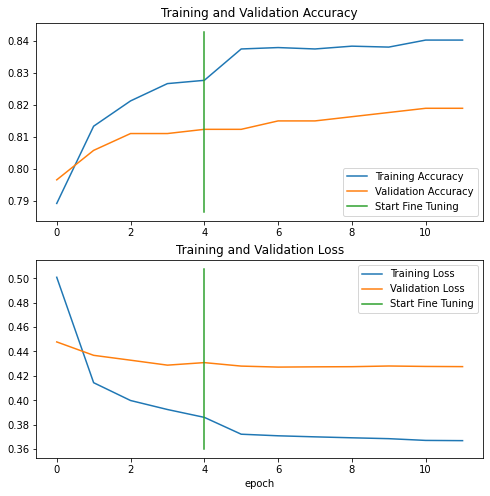

In [ ]:
# Compare performance model before and after fine tuning
from functions import compare_historys
compare_historys(original_history=history_model_6,
                 new_history=history_model_6_fine_tuned,
                 initial_epochs=5)

## **Model 7 : Tensorflow Hub Pretrained Feature Extractor with 10% of training set**

In [ ]:
# Create Tensorboard Callback 
from functions import create_tensorboard_callback

checkpoint_path = "10%_use_model_checkpoints" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [ ]:
# Create subset of 10% training set 
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [ ]:
# Check number of samples in 10% traning set 
print(f"Total training samples: {len(train_sentences)}")
print(f"Total subset samples: {len(train_sentences_10_percent)}")

Total training samples: 6851
Total subset samples: 686


In [ ]:
# Check the distribution of label/class in subset data (10% training set)
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
Name: target, dtype: int64

In [ ]:
# Check the distribution of label/class in training set
pd.Series(train_labels).value_counts()

0    3928
1    2923
Name: target, dtype: int64

In [ ]:
# Create model_7 by clonning model_6 architecture
model_7 = tf.keras.models.clone_model(model_6)

# Compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Check model summary
model_7.summary()

Model: "model_5_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model
history_model_7 = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback("model_logs",
                                                                     "10%_transfer_learning_use_model")])

Saving Tensorboard log files to model_logs/10%_transfer_learning_use_model/20220717-021337
Epoch 1/5
22/22 [==============================] - 8s 104ms/step - loss: 0.6716 - accuracy: 0.6574 - val_loss: 0.6526 - val_accuracy: 0.6903
Epoch 2/5
22/22 [==============================] - 1s 52ms/step - loss: 0.5972 - accuracy: 0.8032 - val_loss: 0.5944 - val_accuracy: 0.7362
Epoch 3/5
22/22 [==============================] - 1s 51ms/step - loss: 0.5178 - accuracy: 0.8149 - val_loss: 0.5398 - val_accuracy: 0.7625
Epoch 4/5
22/22 [==============================] - 1s 41ms/step - loss: 0.4526 - accuracy: 0.8265 - val_loss: 0.5084 - val_accuracy: 0.7677
Epoch 5/5
22/22 [==============================] - 1s 51ms/step - loss: 0.4094 - accuracy: 0.8382 - val_loss: 0.4915 - val_accuracy: 0.7703


In [ ]:
# Make predictions
model_7_preds_probs = model_7.predict(val_sentences)
model_7_preds_probs.shape, model_7_preds_probs[:10] # result prediction probability

((762, 1), array([[0.24043238],
        [0.7683785 ],
        [0.90137184],
        [0.29067948],
        [0.5714999 ],
        [0.83565134],
        [0.8062944 ],
        [0.83358175],
        [0.8554568 ],
        [0.11749922]], dtype=float32))

In [ ]:
# Convert prediction probability to prediction class
model_7_preds = tf.squeeze(tf.round(model_7_preds_probs)) # tf.squeeze removes single dimension
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Model Evaluation
model_7_evaluation = evaluate_prediction(y_true=val_labels, 
                              y_pred=model_7_preds)

model_7_evaluation

{'accuracy': 77.03412073490814,
 'f1': 0.7667059443150692,
 'precision': 0.7755630249535594,
 'recall': 0.7703412073490814}

In [ ]:
# Compare model_7 to model_0 (baseline)
compare_baseline_to_new_model(baseline_evaluation=model_0_evaluation,
                              new_model_evaluation=model_7_evaluation)

Baseline accuracy: 79.27, New_model accuracy: 77.03, Difference: -2.23
Baseline precision: 0.81, New_model precision: 0.78, Difference: -0.04
Baseline recall: 0.79, New_model recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New_model f1: 0.77, Difference: -0.02


## **Model 0 (a) : Naive Bayes with 10% training set**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0_a = Pipeline([("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

# fit the pipeline to the training set
model_0_a.fit(train_sentences_10_percent, train_labels_10_percent)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate the model on validation set
model_0_a_accuracy = model_0_a.score(val_sentences, val_labels)
print(f"Baseline model (a) achieves an accuracy of {model_0_a_accuracy*100:.2f}%")

Baseline model (a) achieves an accuracy of 70.60%


In [ ]:
# Make predictions
model_0_a_preds = model_0_a.predict(val_sentences)
model_0_a_preds[:10]

array([0, 0, 1, 0, 0, 1, 1, 1, 0, 0])

In [ ]:
# Model evaluation
model_0_a_evaluation = evaluate_prediction(y_true=val_labels, 
                              y_pred=model_0_a_preds)

model_0_a_evaluation

{'accuracy': 70.60367454068242,
 'f1': 0.6747604694140249,
 'precision': 0.7777273287601192,
 'recall': 0.7060367454068242}

In [ ]:
# Compare model_7 to model_0_a (baseline)
compare_baseline_to_new_model(baseline_evaluation=model_0_a_evaluation,
                              new_model_evaluation=model_7_evaluation)

Baseline accuracy: 70.60, New_model accuracy: 77.03, Difference: 6.43
Baseline precision: 0.78, New_model precision: 0.78, Difference: -0.00
Baseline recall: 0.71, New_model recall: 0.77, Difference: 0.06
Baseline f1: 0.67, New_model f1: 0.77, Difference: 0.09


## **Final Model :**

### **Comparing Model Performances**

In [ ]:
# Combine model evaluations into a dataframe
model_evaluations = pd.DataFrame({"baseline": model_0_evaluation,
                                  "simple_dense": model_1_evaluation,
                                  "LSTM": model_2_evaluation,
                                  "GRU":model_3_evaluation,
                                  "bidirectional": model_4_evaluation,
                                  "1D-CNN": model_5_evaluation,
                                  "tf_hub_USE": model_6_evaluation,
                                  "tf_hub_USE_fine_tuned": model_6_fine_tuned_evaluation}).T
model_evaluations

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.740157,0.791492,0.787402,0.784697
LSTM,75.065617,0.751008,0.750656,0.748927
GRU,76.771654,0.767545,0.767717,0.766793
bidirectional,76.640420,0.766590,0.766404,0.765121
1D-CNN,77.821522,0.780752,0.778215,0.775881
tf_hub_USE,81.233596,0.814880,0.812336,0.810687
tf_hub_USE_fine_tuned,81.889764,0.820563,0.818898,0.817642


In [ ]:
# Scale the accuracy values
model_evaluations["accuracy"] = model_evaluations["accuracy"]/100

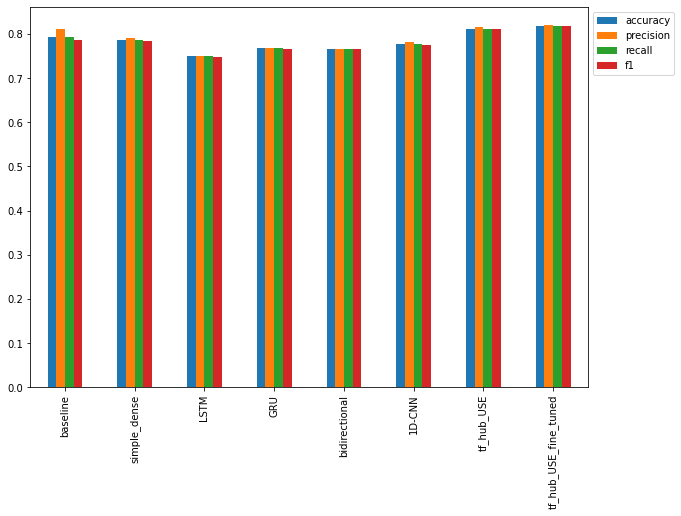

In [ ]:
# Plot model evaluation metrics
model_evaluations.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1,1))

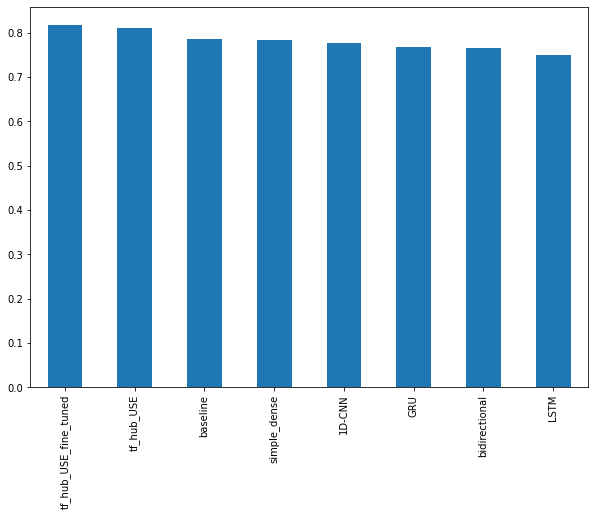

In [ ]:
# Sort model evaluation by f1-score metric
model_evaluations.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7))

### **Model Ensembling**

Model Ensembling **combines multiple different models to make a predictions**. The idea of model ensembing is that if several uncorrelated models (different type of models) agree on prediction, then a prediction must be more robust than a prediction made by a singular model. These models were all trained on the same data, and they have a different way of finding patterns in data.

There are few ways to combine models in a classification problem:
1. **Averaging** - Take the output prediction probabilities of each model for each sample, combine them and then average them.
2. **Majority vote (mode)** - Make class predictions with each of models on all samples, the predicted class is the one in majority. For example, if three different models predict [1, 0, 1] respectively, the majority class is 1, therefore, that would be the predicted label.
3. **Model stacking** - Take the outputs of each of your chosen models and use them as inputs to another model.

Model Ensembling : baseline model (model_0), LSTM model (model_2), and TF-Hub USE model (model_6)

**1. Averaging Models**

In [ ]:
combined_pred_probs =model_0_pred_probs + tf.squeeze(model_2_preds_probs, axis=1) + tf.squeeze(model_6_fine_tuned_preds_probs, axis=1)
averaging_combined_preds = tf.round(combined_pred_probs/3)
averaging_combined_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Model evaluation
averaging_ensemble_026_evaluation = evaluate_prediction(y_true=val_labels, 
                                                        y_pred=averaging_combined_preds)
averaging_ensemble_026_evaluation

{'accuracy': 78.08398950131233,
 'f1': 0.7806452350205135,
 'precision': 0.7805831064048222,
 'recall': 0.7808398950131233}

In [ ]:
# Add ensemble model to model_evaluations dataframe
model_evaluations.loc["averaging_esemble"] = averaging_ensemble_026_evaluation

In [ ]:
# Scale the accuracy value
model_evaluations.loc["averaging_esemble"]["accuracy"] = (model_evaluations.loc["averaging_esemble"]["accuracy"])/100

**2. Majority Vote Models**

In [ ]:
pred_temp = []
majority_vote_pred = []

for i in range(len(val_sentences)):
  pred_temp.append(model_0_preds[i])
  pred_temp.append(int(model_2_preds[i].numpy()))
  pred_temp.append(int(model_6_fine_tuned_preds[i].numpy()))
  mode = max(set(pred_temp), key=pred_temp.count)
  majority_vote_pred.append(mode)
  pred_temp = []

majority_vote_pred[:10]

[0, 1, 1, 0, 0, 1, 1, 1, 1, 0]

In [ ]:
len(majority_vote_pred)

762

In [ ]:
# Model evaluation
majority_vote_ensemble_026_evaluation = evaluate_prediction(y_true=val_labels, 
                                                        y_pred=majority_vote_pred)
majority_vote_ensemble_026_evaluation

{'accuracy': 80.5774278215223,
 'f1': 0.8021877886035522,
 'precision': 0.8147496935474905,
 'recall': 0.8057742782152231}

In [ ]:
# Add ensemble model to model_evaluations dataframe
model_evaluations.loc["majority_vote_esemble"] = majority_vote_ensemble_026_evaluation

In [ ]:
# Scale the accuracy value
model_evaluations.loc["majority_vote_esemble"]["accuracy"] = (model_evaluations.loc["majority_vote_esemble"]["accuracy"])/100

In [ ]:
model_evaluations

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.787402,0.791492,0.787402,0.784697
LSTM,0.750656,0.751008,0.750656,0.748927
GRU,0.767717,0.767545,0.767717,0.766793
bidirectional,0.766404,0.766590,0.766404,0.765121
1D-CNN,0.778215,0.780752,0.778215,0.775881
tf_hub_USE,0.812336,0.814880,0.812336,0.810687
tf_hub_USE_fine_tuned,0.818898,0.820563,0.818898,0.817642
averaging_esemble,0.780840,0.780583,0.780840,0.780645
majority_vote_esemble,0.805774,0.814750,0.805774,0.802188


The accuracy of prediction by majority-voting the prediction probabilities of 3 models is higher than the the accuracy of predicting by averaging. However, this values still does not perform better than Fine tuned TF_Hub USE model.

## **Evaluate Final Model**

### **Finding the Most Wrong Predictions**

In [ ]:
# Create dataframe of prediction result on validation set
val_preds = pd.DataFrame({"text": val_sentences,
                          "target": val_labels,
                          "pred": model_6_fine_tuned_preds,
                          "pred_probs": tf.squeeze(model_6_fine_tuned_preds_probs)})
val_preds.head()

,text,target,pred,pred_probs
4955,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.158055
584,FedEx no longer to transport bioterror germs i...,0,1.0,0.774859
7411,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.990229
5950,@camilacabello97 Internally and externally scr...,1,0.0,0.200230
5541,Radiation emergency #preparedness starts with ...,1,1.0,0.745679


In [ ]:
# Find the most wrong predictions
most_wrong_preds = val_preds[val_preds["target"] != val_preds["pred"]].sort_values("pred_probs", ascending=False)
most_wrong_preds

,text,target,pred,pred_probs
1206,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.921092
578,FedEx will no longer transport bioterror patho...,0,1.0,0.894714
4821,@noah_anyname That's where the concentration c...,0,1.0,0.867376
1186,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.859500
3991,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.851407
...,...,...,...,...
6160,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.039967
6221,I get to smoke my shit in peace,1,0.0,0.039265
5464,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.037052
2250,Why are you deluged with low self-image? Take ...,1,0.0,0.035882


In [ ]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong_preds[:10].itertuples(): # loop through the top 10 rows
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9210922122001648
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.89471435546875
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8673757910728455
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8595004081726074
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1, Prob: 0.8514074683189392
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.8391731977462769
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob

In [ ]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong_preds[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.06411667168140411
Text:
VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP WATCH 241487 http://t.co/yFy3nkkcoH http://t.co/KNEhVvOHVK

----

Target: 1, Pred: 0, Prob: 0.061807479709386826
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.05916564166545868
Text:
'The way you move is like a full on rainstorm and I'm a house of cards'

----

Target: 1, Pred: 0, Prob: 0.057830989360809326
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.045505423098802567
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.03996706381440163
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, 

In [ ]:
# save the file
most_wrong_preds.to_csv("tweets_disaster_most_wrong_prediction.csv")

### **Confusion Matrix**

Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.

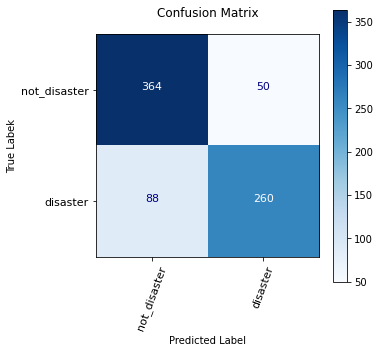

In [ ]:
# Plot confusion matrix
from functions import create_confusion_matrix
create_confusion_matrix(y_true=val_labels,
                        y_pred=model_6_fine_tuned_preds,
                        classes=['not_disaster','disaster'],
                        figsize=(5,5),
                        text_size=11,
                        norm=False,
                        savefig=True)

In [ ]:
# classification report

from sklearn.metrics import classification_report
print(classification_report(val_labels, model_6_fine_tuned_preds))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       414
           1       0.84      0.75      0.79       348

    accuracy                           0.82       762
   macro avg       0.82      0.81      0.82       762
weighted avg       0.82      0.82      0.82       762



### **Train Final Model on the Whole Training Set**

In [ ]:
# Create EarlyStopping Callback
## This callback stops training when a monitored metric has stopped improving.

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss",
                                                  patience=5) # if val_loss increases for 3 epochs, then training will be stopped

In [ ]:
# Create learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",
                                                 factor=0.2,
                                                 patience=3,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [ ]:
# Create Tensorboard Callback 
from functions import create_tensorboard_callback

checkpoint_path = "whole_train_fine_tuned_use_model_checkpoints" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [ ]:
whole_train_sentences = train["text"]
whole_train_labels = train["target"]

In [ ]:
# Re-Fit the model
history_model_6_whole_train_fine_tuned = model_6.fit(whole_train_sentences,
                              whole_train_labels,
                              epochs=100,
                              callbacks=[create_tensorboard_callback("model_logs",
                                                                     "whole_train_fine_tuned_transfer_learning_use_model"),
                                         early_stopping,
                                         reduce_lr])

Saving Tensorboard log files to model_logs/whole_train_fine_tuned_transfer_learning_use_model/20220717-021400
Epoch 1/100
238/238 [==============================] - 3s 10ms/step - loss: 0.3729 - accuracy: 0.8383 - lr: 2.0000e-05
Epoch 2/100
238/238 [==============================] - 2s 10ms/step - loss: 0.3727 - accuracy: 0.8374 - lr: 2.0000e-05
Epoch 3/100
238/238 [==============================] - 2s 10ms/step - loss: 0.3725 - accuracy: 0.8374 - lr: 2.0000e-05
Epoch 4/100
238/238 [==============================] - 2s 10ms/step - loss: 0.3723 - accuracy: 0.8370 - lr: 2.0000e-05
Epoch 5/100
238/238 [==============================] - 2s 10ms/step - loss: 0.3721 - accuracy: 0.8376 - lr: 2.0000e-05
Epoch 6/100
238/238 [==============================] - 2s 10ms/step - loss: 0.3719 - accuracy: 0.8382 - lr: 2.0000e-05
Epoch 7/100
238/238 [==============================] - 2s 10ms/step - loss: 0.3717 - accuracy: 0.8378 - lr: 2.0000e-05
Epoch 8/100
238/238 [==============================] - 2s

### **Save the Model**

In [ ]:
# Save Fine tuned TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

### **Making Predictions on Testing Set**

In [ ]:
test_sentences = test["text"].to_list()
test_samples = random.sample(test_sentences, 15)
for i in test_samples:
  pred_prob = tf.squeeze(model_6.predict([i]))
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{i}\n")
  print("-----\n")

Pred: 0, Prob: 0.3417355716228485
Text:
@kdudakia I get that there has been a massive turn away from Labour but that does not = electoral landslide. Credits tories too much and...

-----

Pred: 0, Prob: 0.06624694168567657
Text:
People are bagging on Rousey's body? Shit I'd love to have a body like that. Those who are ridiculing her are probably dudes in skinny jeans

-----

Pred: 0, Prob: 0.13969890773296356
Text:
No one on the south shore knows how to make good coffee and I'm trapped in a living hell

-----

Pred: 1, Prob: 0.6715134382247925
Text:
Aurora Prediction: Kp: 3.33(11:16) 4.67(14:16) AK (earth 2.00) 75% Status: Low Storm

-----

Pred: 1, Prob: 0.9308799505233765
Text:
Motorcyclist bicyclist injured in Denver collision on Broadway: At least two people were taken to a localÛ_ http://t.co/PMv8ZDFnmr

-----

Pred: 1, Prob: 0.5323982834815979
Text:
pretty sure i almost drowned 26 times in the pool today thanks to abrianna

-----

Pred: 1, Prob: 0.6232441663742065
Text:
Thought 

In [ ]:
list_pred = []
for i, column in test.iterrows():
  pred_prob = tf.squeeze(model_6.predict([column["text"]]))
  pred = tf.round(pred_prob).numpy()
  list_pred.append(pred)

test["target"] = list_pred
test.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1.0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1.0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1.0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1.0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1.0


**For Kaggle Competition Submission**

In [ ]:
test.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [ ]:
submission = test[['id','target']]
submission.head(3)

,id,target
0,0,1.0
1,2,1.0
2,3,1.0


In [ ]:
len(submission)

3263

In [ ]:
submission['target'].value_counts()

0.0    2031
1.0    1232
Name: target, dtype: int64

In [ ]:
submission.to_csv('submission.csv')

### **Predictiong on Unseen Tweets**

In [ ]:
# Make a function to predict

def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction (not real disaster/ real disaster) on sentence.

  Returns the sentence, the predicted label, and the prediction probability
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [ ]:
# Tweet source : https://twitter.com/NowMyNews/status/1548031290204491777
tweet_1 = "Video shows fireworks drama in France: two dead after explosion in crowd"

# Tweet source : https://twitter.com/WeAreProtestors/status/1546127265029050368
tweet_2 = "The manufactured energy crisis rolls on with a massive explosion at a natural gas plant in Oklahoma."

# Tweet source : https://twitter.com/vinnie82d/status/1548019292372750339
tweet_3 = "@IKEAUSA Thank you very much. Your glass desk exploded. Not only will this be a pain to clean up, I now have a million+ shards of glass in my carpet."

In [ ]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6, 
                    sentence=tweet_1)

Pred: 1.0 (real disaster) Prob: 0.9877524375915527
Text:
Video shows fireworks drama in France: two dead after explosion in crowd


In [ ]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6, 
                    sentence=tweet_2)

Pred: 1.0 (real disaster) Prob: 0.9872179627418518
Text:
The manufactured energy crisis rolls on with a massive explosion at a natural gas plant in Oklahoma.


In [ ]:
# Predict on diaster Tweet 3
predict_on_sentence(model=model_6, 
                    sentence=tweet_3)

Pred: 0.0 (not real disaster) Prob: 0.11066947132349014
Text:
@IKEAUSA Thank you very much. Your glass desk exploded. Not only will this be a pain to clean up, I now have a million+ shards of glass in my carpet.


Prediction on unseen tweets results 3 out of 3 predictions are correct.

### **Finding the Speed/Score Trade Off**

In [ ]:
# Calculate the time of predictions
import time

def pred_timer(model, samples):
  """
  Calculates how long a model could make predictions on samples.

  Args:
    model : a trained model
    samples : a list of samples
  
  Returns:
    total_time : total elapsed time for model to make predictions on samples
    time_per_pred : time in second per single sample
  """
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time - start_time
  time_per_pred = total_time/len(val_sentences)
  return total_time, time_per_pred

In [ ]:
# Calculate TF-Hub USE Model (model_6) prediction time
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.235118625000041, 0.0003085546259843058)

In [ ]:
# Calculate Baseline Model (model_0) prediction time
model_0_total_pred_time, model_0_time_per_pred = pred_timer(model_0, val_sentences)
model_0_total_pred_time, model_0_time_per_pred

(0.02175747000001138, 2.855311023623541e-05)

Text(0, 0.5, 'F1-Score')

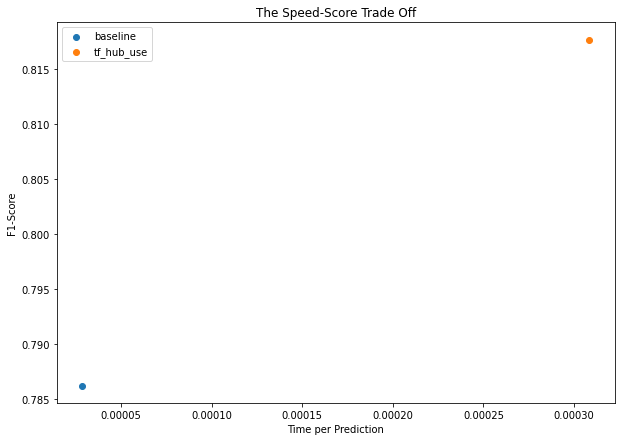

In [ ]:
# Visualize time per prediction and f1_score
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(model_0_time_per_pred, model_0_evaluation["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_fine_tuned_evaluation["f1"], label="tf_hub_use")
plt.legend()
plt.title("The Speed-Score Trade Off")
plt.xlabel("Time per Prediction")
plt.ylabel("F1-Score")

According to plot above, the best performing model takes time 11x longer per prediction, in turn results F1-Score 0.032 higher than baseline model.